<a href="https://colab.research.google.com/github/adampotton/Cognitive_AI_CW/blob/main/Q2D_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code builds upon a classic CNN model for classifying shoes, by adding attention layers that look for specifics in each image.


*   Attention weights are optimized to highlight regions that contribute to reducing the loss.
*   In practice, attention improves interpretability, helping us understand what the network "thinks" is important for making decisions



### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Define Model with Attention Layers

In [42]:
img_size_div4 = 45 # Image size

class AttentionLayer(nn.Module):
    def __init__(self, in_channels):
        super(AttentionLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)  # Generates a single channel score map

    def forward(self, x):
        attention_weights = torch.sigmoid(self.conv(x))  # Sigmoid to get values in range [0, 1]
        return attention_weights, x * attention_weights

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)  # First convolutional layer
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)  # Second convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer with 50% probability of dropping units
        self.fc1 = nn.Linear(16 * img_size_div4 * img_size_div4, 128)  # Reduced from 256 to 128
        self.fc2 = nn.Linear(128, 3)  # Output layer for 3 classes (nike, adidas, converse)
        self.attn1 = AttentionLayer(8) # First attention layer
        self.attn2 = AttentionLayer(16) # Second attention layer

    def forward(self, x, attn_on = True):
        if attn_on:
            x = self.pool(torch.relu(self.conv1(x))) # First convolutional layer with ReLU and pooling
            attn1_weights, x = self.attn1(x) # First attention layer
            x = self.pool(torch.relu(self.conv2(x)))  # Second convolutional layer with ReLU and pooling
            attn2_weights, x = self.attn2(x)  # Second attention layer
        else:
            x = self.pool(torch.relu(self.conv1(x)))  # First convolutional layer with ReLU and pooling
            x = self.pool(torch.relu(self.conv2(x)))  # Second convolutional layer with ReLU and pooling
        x = self.dropout(x)  # Apply dropout
        x = x.view(-1, 16 * img_size_div4 * img_size_div4)  # Flatten the output for the fully connected layer
        x = torch.relu(self.fc1(x))  # Fully connected layer with ReLU
        x = self.dropout(x) # Apply dropout to the fully connected layer output
        x = self.fc2(x)  # Output layer
        return x, attn1_weights, attn2_weights

### Load and Edit Data

In [51]:
img_size = img_size_div4 * 4 # Define image size

train_transform = transforms.Compose([ # Define transformations for training
    transforms.Resize((img_size, img_size)),  # Resize images to the desired size
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomRotation(degrees=10),   # Randomly rotate images by up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust color properties
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Randomly translate images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

test_transform = transforms.Compose([ # Define transformations for testing (no augmentation)
    transforms.Resize((img_size, img_size)),  # Resize images to the desired size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Define paths to your train and test directories
train_dir = '/content/drive/MyDrive/Cognitive_AI/shoes/train'
test_dir = '/content/drive/MyDrive/Cognitive_AI/shoes/test'

batch_size = 20
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform) # Load datasets using ImageFolder
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Create DataLoader for batching
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Train the Model

In [ ]:
lr = 0.0006 # Learning rate
num_epochs = 30 # Number of epochs for training
attn_on = True # Turning on or off the attention mechanism

model = CNN() # Initialise a model
criterion = nn.CrossEntropyLoss()  # Loss function and optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr)

attention_maps = {"attn1": [], "attn2": []}
fixed_image, _ = next(iter(test_loader))  # Assuming test_loader is defined
fixed_image = fixed_image[0].unsqueeze(0)  # Select the first image and add batch dimension

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader: # Loop through images and labels to train
        optimizer.zero_grad()
        output,_,_ = model(images,attn_on = attn_on)
        loss = criterion(output, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    model.eval()  # Switch to evaluation mode to save attention maps for each epoch
    with torch.no_grad():
        _, attn1_weights, attn2_weights = model(fixed_image)
        attention_maps["attn1"].append(attn1_weights.squeeze().cpu().detach().numpy())
        attention_maps["attn2"].append(attn2_weights.squeeze().cpu().detach().numpy())

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")


Epoch 1/30, Loss: 1.1212, Accuracy: 0.3390
Epoch 2/30, Loss: 1.0906, Accuracy: 0.3826
Epoch 3/30, Loss: 1.0824, Accuracy: 0.3980
Epoch 4/30, Loss: 1.0759, Accuracy: 0.4248
Epoch 5/30, Loss: 1.0600, Accuracy: 0.4205
Epoch 6/30, Loss: 1.0573, Accuracy: 0.4346
Epoch 7/30, Loss: 1.0577, Accuracy: 0.4459
Epoch 8/30, Loss: 1.0309, Accuracy: 0.4571
Epoch 9/30, Loss: 1.0344, Accuracy: 0.4599
Epoch 10/30, Loss: 1.0248, Accuracy: 0.4880
Epoch 11/30, Loss: 0.9998, Accuracy: 0.5148
Epoch 12/30, Loss: 0.9889, Accuracy: 0.5443
Epoch 13/30, Loss: 0.9947, Accuracy: 0.5232
Epoch 14/30, Loss: 0.9846, Accuracy: 0.5260
Epoch 15/30, Loss: 0.9607, Accuracy: 0.5204
Epoch 16/30, Loss: 0.9758, Accuracy: 0.5260
Epoch 17/30, Loss: 0.9738, Accuracy: 0.5302
Epoch 18/30, Loss: 0.9470, Accuracy: 0.5598
Epoch 19/30, Loss: 0.9224, Accuracy: 0.5809
Epoch 20/30, Loss: 0.9461, Accuracy: 0.5570
Epoch 21/30, Loss: 0.9487, Accuracy: 0.5724
Epoch 22/30, Loss: 0.9212, Accuracy: 0.5837
Epoch 23/30, Loss: 0.9047, Accuracy: 0.58

### Testing the Model

In [50]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need to track gradients during evaluation
    for images, labels in test_loader:
        output,_,_ = model(images)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.6842


### Code for Visualising an Image & Attention Layers

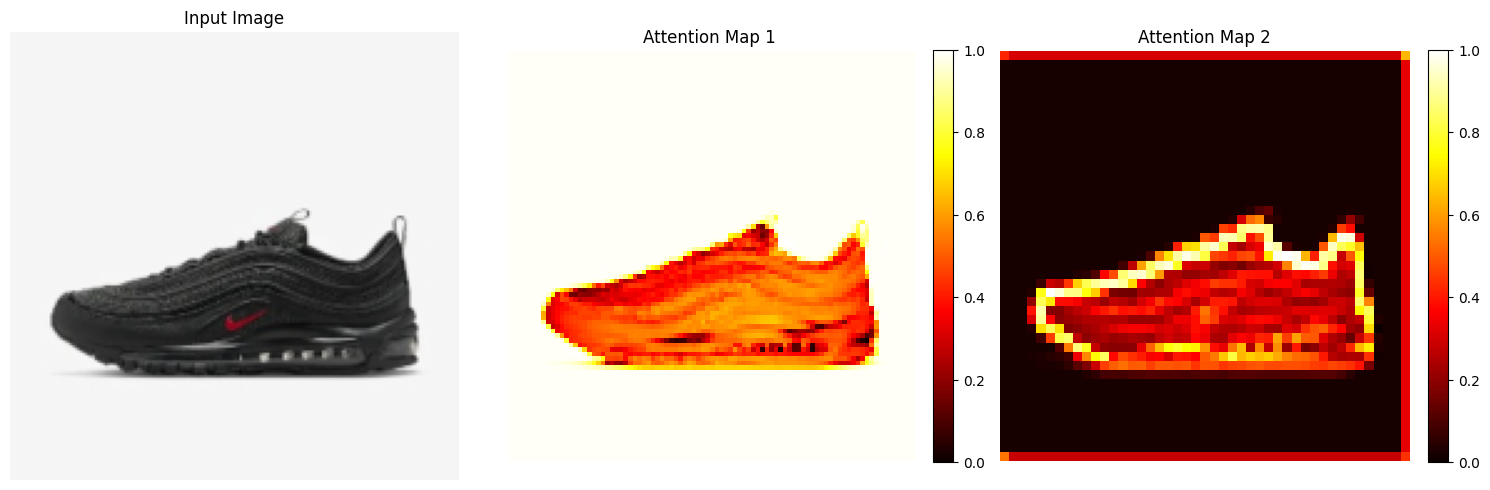

In [46]:
def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1)
    std = torch.tensor(std).view(1, 3, 1, 1)
    return img * std + mean

def visualize_attention(model, loader):
    image, label = random.choice(list(loader))
    image = image[0].unsqueeze(0)  # Single image, keep batch dimension
    label = label[0].item()

    original_image = denormalize(image.clone(), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    original_image = original_image.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    original_image = np.clip(original_image, 0, 1)

    model.eval() # Pass the image through the model
    with torch.no_grad():
        output, attn1_weights, attn2_weights = model(image)

    attn1_map = attn1_weights.squeeze().cpu().detach().numpy()  # Convert attention weights to the shape of the feature map
    attn2_map = attn2_weights.squeeze().cpu().detach().numpy()

    attn1_map = (attn1_map - attn1_map.min()) / (attn1_map.max() - attn1_map.min()) # Normalize the attention maps to [0, 1] for visualization
    attn2_map = (attn2_map - attn2_map.min()) / (attn2_map.max() - attn2_map.min())

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(original_image) # Plot the original image
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    im1 = axes[1].imshow(attn1_map, cmap='hot') # Plot attention map 1
    axes[1].set_title('Attention Map 1')
    axes[1].axis('off')
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    im2 = axes[2].imshow(attn2_map, cmap='hot') # Plot attention map 2
    axes[2].set_title('Attention Map 2')
    axes[2].axis('off')
    fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

visualize_attention(model, test_loader) # Visualize the attention maps for this image

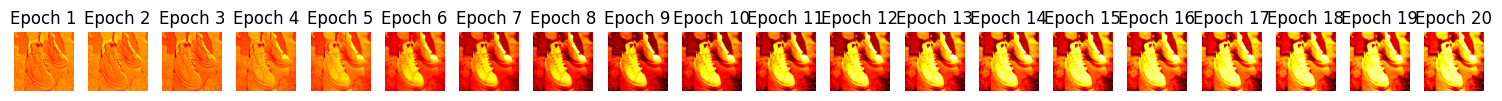

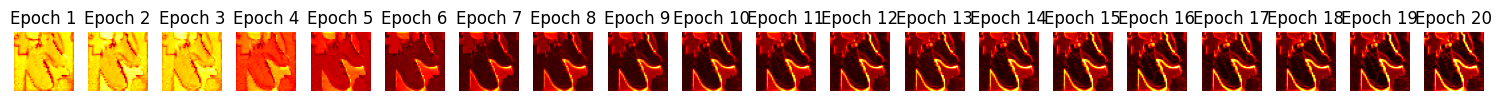

In [47]:
def plot_attention_evolution(attention_maps, layer_name, num_epochs, save_path=None):
    """
    Visualizes the evolution of attention maps for a given layer over epochs.

    Args:
        attention_maps (dict): Dictionary containing attention maps for each layer.
        layer_name (str): Key in the attention_maps dictionary ("attn1" or "attn2").
        num_epochs (int): Total number of epochs.
        save_path (str): Optional path to save the visualization.
    """
    fig, axes = plt.subplots(1, num_epochs, figsize=(15, 5))
    cmap = 'hot'  # Colormap for visualization

    for epoch in range(num_epochs):
        attn_map = attention_maps[layer_name][epoch]
        attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())  # Normalize

        ax = axes[epoch]
        ax.imshow(attn_map, cmap=cmap)
        ax.set_title(f'Epoch {epoch+1}')
        ax.axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

# Plot evolution for attention layer 1
plot_attention_evolution(attention_maps, "attn1", num_epochs=num_epochs)

# Plot evolution for attention layer 2
plot_attention_evolution(attention_maps, "attn2", num_epochs=num_epochs)
